In [68]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))
import joblib

# Import torch modules
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
import json
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')

# Import Scikit-learn modules
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, label_binarize

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop = set(stopwords.words('english'))
import joblib

# Import torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


#### 1. Check the file encoding and load Data

In [69]:
# Import chardet to detect file encoding
import chardet
filename = 'Sentences_75Agree.txt'
def detect_encoding(filename):
    with open(filename, 'rb') as f:
        raw_data = f.read(10000)  # 读取前10000字节用于检测
        result = chardet.detect(raw_data)
    return result['encoding']

file_encoding = detect_encoding(filename)
print(f"file format: {file_encoding}")

file format: ISO-8859-1


In [70]:
def load_finphrase(filename):
    """
    Clean and process the FinancialPhraseBank data.
    
    Input:
        - filename: The name of the file to load.
    
    Output:
        - DataFrame: The loaded and cleaned FinancialPhraseBank data.
    """
    try:
        # Read the file (ensure the delimiter is correct!)
        df = pd.read_csv(
            filename,
            sep='@',  # Verify if the delimiter is correct (if comma separated, change to sep=',')
            engine='python',
            header=None,
            names=['sentence', 'label'],
            encoding='latin1'
        )
        print('Total number of records in the file:', df.shape[0])
        
        # Remove duplicate rows
        df.drop_duplicates(inplace=True)
        print('Total number after dropping duplicates:', df.shape[0])
        
        # Process missing values: remove rows with missing labels
        missing_count = df['label'].isnull().sum()
        if missing_count > 0:
            print(f"Deleting {missing_count} rows with missing labels.")
            df.dropna(subset=['label'], inplace=True)
        
        df.reset_index(drop=True, inplace=True)
        return df
    
    except FileNotFoundError:
        print(f"File not found: {filename}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [71]:
filename = 'Sentences_75Agree.txt'
df_finphrase = load_finphrase(filename)
df_finphrase.head()

Total number of records in the file: 3453
Total number after dropping duplicates: 3448


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,With the new production plant the company woul...,positive
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,"In the third quarter of 2010 , net sales incre...",positive
4,Operating profit rose to EUR 13.1 mn from EUR ...,positive


#### 做好编码器后续用

In [72]:
if df_finphrase is not None:
    # Perform label encoding (retain the original label column)
    le = LabelEncoder()
    df_finphrase['label_encoded'] = le.fit_transform(df_finphrase['label'])
    
    # Save the label encoder to a file
    joblib.dump(le, 'label_encoder.pkl')

In [73]:
from sklearn.model_selection import train_test_split

if df_finphrase is not None:
    # Split the data into features and labels
    X = df_finphrase['sentence']
    y = df_finphrase['label_encoded']
    
    # Split data into training and test sets with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        stratify=y, 
        random_state=42
    )
    
    # Output distribution statistics
    print("\nTraining/Test distribution:")
    print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X):.1%})")
    print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X):.1%})")
    
    print("\nTraining set label distribution:")
    print(y_train.value_counts().sort_index())
    print("\nTest set label distribution:")
    print(y_test.value_counts().sort_index())
    
    print("\nLabel encoding mapping:")
    for i, label in enumerate(le.classes_):
        print(f"{i} -> {label}")


Training/Test distribution:
Training set: 2758 samples (80.0%)
Test set: 690 samples (20.0%)

Training set label distribution:
label_encoded
0     336
1    1713
2     709
Name: count, dtype: int64

Test set label distribution:
label_encoded
0     84
1    428
2    178
Name: count, dtype: int64

Label encoding mapping:
0 -> negative
1 -> neutral
2 -> positive


#### 可视化

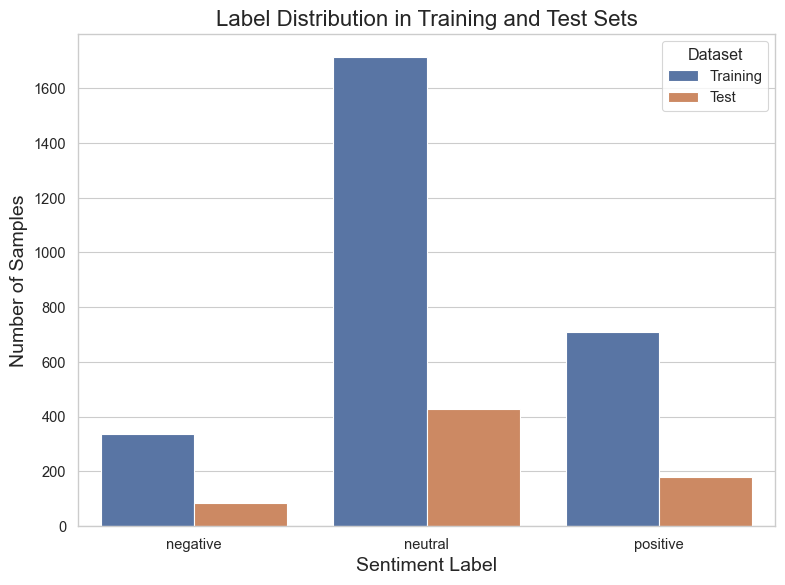

In [74]:
# Set theme for publication-quality plots
sns.set_theme(context='paper', style='whitegrid', font_scale=1.2)

# Prepare data for label distribution visualization
# Get value counts for training and test sets (sorted by label index)
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

# Create DataFrames for training and test set counts
df_train_counts = pd.DataFrame({
    'Label': le.classes_,
    'Count': train_counts.values,
    'Dataset': 'Training'
})

df_test_counts = pd.DataFrame({
    'Label': le.classes_,
    'Count': test_counts.values,
    'Dataset': 'Test'
})

# Concatenate the two DataFrames for combined plotting
df_counts = pd.concat([df_train_counts, df_test_counts], ignore_index=True)

# Create a figure with one subplot for the bar plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the bar chart showing the label distribution for both Training and Test sets
sns.barplot(x='Label', y='Count', hue='Dataset', data=df_counts, ax=ax)
ax.set_title("Label Distribution in Training and Test Sets", fontsize=16)
ax.set_xlabel("Sentiment Label", fontsize=14)
ax.set_ylabel("Number of Samples", fontsize=14)
ax.legend(title='Dataset')
plt.tight_layout()
plt.show()


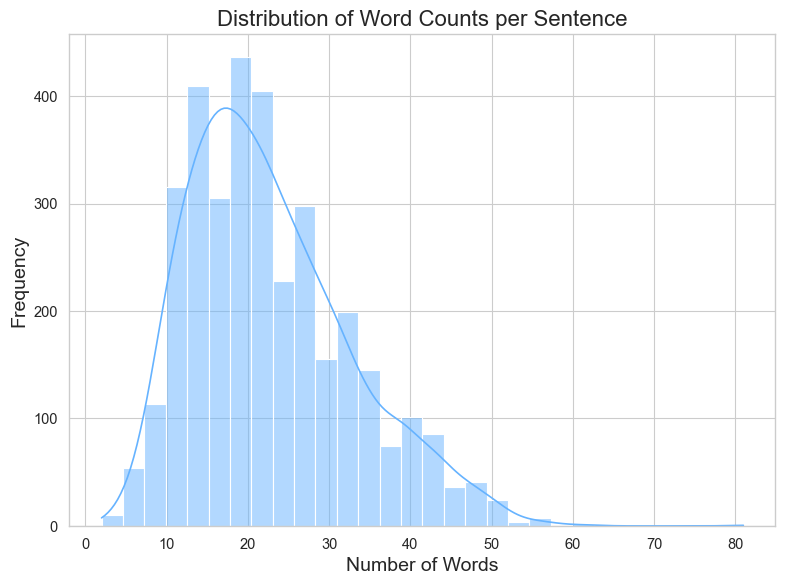

In [75]:
# If the data is loaded, compute the word count for each sentence and plot the distribution
if df_finphrase is not None:
    # Calculate the number of words in each sentence by splitting on whitespace
    df_finphrase['word_count'] = df_finphrase['sentence'].apply(lambda s: len(s.split()))
    
    # Set the theme for publication-quality plots
    sns.set_theme(context='paper', style='whitegrid', font_scale=1.2)
    
    # Create a figure for the word count distribution
    plt.figure(figsize=(8, 6))
    
    # Plot a histogram (bar chart) of word counts with a KDE overlay using the same blue color (#66b3ff)
    sns.histplot(df_finphrase['word_count'], bins=30, kde=True, color='#66b3ff')
    
    # Set the title and axis labels
    plt.title("Distribution of Word Counts per Sentence", fontsize=16)
    plt.xlabel("Number of Words", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


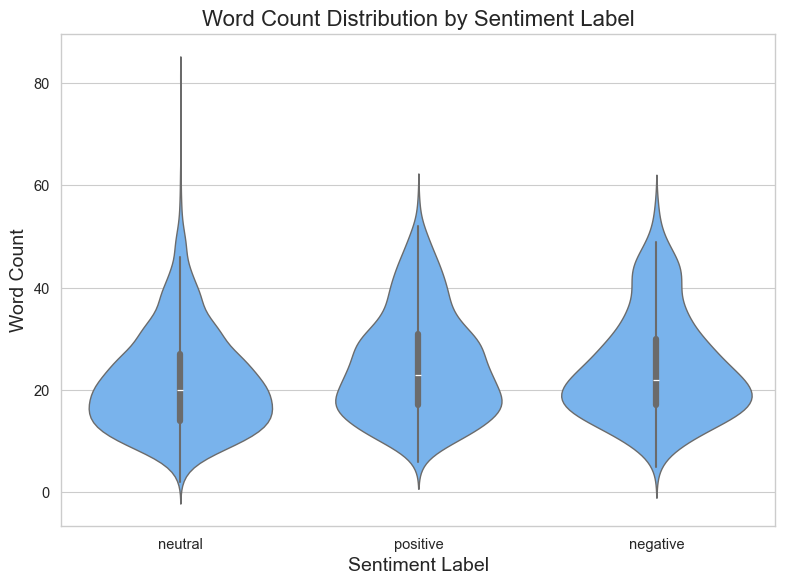

In [76]:
# Set the theme for publication-quality plots
sns.set_theme(context='paper', style='whitegrid', font_scale=1.2)

# Ensure the 'word_count' column exists; if not, compute it
if 'word_count' not in df_finphrase.columns:
    df_finphrase['word_count'] = df_finphrase['sentence'].apply(lambda s: len(s.split()))

# Create a violin plot to show word count distribution by sentiment label
plt.figure(figsize=(8, 6))
sns.violinplot(x='label', y='word_count', data=df_finphrase, color='#66b3ff')
plt.title("Word Count Distribution by Sentiment Label", fontsize=16)
plt.xlabel("Sentiment Label", fontsize=14)
plt.ylabel("Word Count", fontsize=14)
plt.tight_layout()
plt.show()


In [77]:
# Cell 1: Import Necessary Libraries and Set Up Stop Words
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from nltk.util import ngrams
from wordcloud import WordCloud
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Set up stopwords (using NLTK's English stopwords)
stop = set(stopwords.words('english'))

# Optionally, if you have a training DataFrame named 'train_df', use it.
# If not, you can use your df_finphrase DataFrame.
# For this example, we'll assume train_df exists.
# train_df = df_finphrase  # Uncomment or adjust as needed

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [78]:
import re
import string

def create_clean_corpus(df, min_token_length=2):
    """
    Create a cleaned corpus from the 'sentence' column in the DataFrame.
    This function:
      - Converts text to lowercase.
      - Uses regex to extract only word characters (letters, numbers, and underscores).
      - Filters out tokens shorter than min_token_length.
      
    Parameters:
      - df: DataFrame containing a 'sentence' column.
      - min_token_length: minimum length of token to be included (default=2).
    
    Returns:
      - corpus: a list of cleaned tokens.
    """
    corpus = []
    # Regular expression pattern: \b\w+\b matches one or more word characters within word boundaries.
    pattern = re.compile(r'\b\w+\b')
    for sentence in df['sentence']:
        # Convert the sentence to lowercase
        sentence = sentence.lower()
        # Find all tokens matching the pattern
        tokens = pattern.findall(sentence)
        # Filter tokens that meet the minimum length requirement
        tokens = [token for token in tokens if len(token) >= min_token_length]
        corpus.extend(tokens)
    return corpus

# Use the updated function to generate the corpus
corpus = create_clean_corpus(df_finphrase)


In [79]:
# Cell 3: Define Functions to Get Frequent Stop Words and Non-Stop Words
def get_frequent_stop_words(corpus, top_n=10):
    """
    Returns the top_n frequent stop words in the corpus.
    """
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return zip(*top)

def get_frequent_nonstop_words(corpus, top_n=10):
    """
    Returns the top_n frequent non-stop words in the corpus.
    """
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1
    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return zip(*top)

# Get and print top frequent stop words and non-stop words
stop_words, stop_counts = get_frequent_stop_words(corpus)
print("Top frequent stop words:", list(stop_words))
print("Counts:", list(stop_counts))

nonstop_words, nonstop_counts = get_frequent_nonstop_words(corpus)
print("Top frequent non-stop words:", list(nonstop_words))
print("Counts:", list(nonstop_counts))

Top frequent stop words: ['the', 'of', 'in', 'and', 'to', 'for', 'is', 'from', 'will', 'on']
Counts: [4257, 2311, 2095, 1792, 1713, 843, 636, 633, 557, 495]
Top frequent non-stop words: ['eur', 'company', 'mn', 'profit', 'net', 'sales', 'million', 'finnish', 'said', 'year']
Counts: [916, 575, 500, 385, 379, 377, 366, 350, 344, 338]


C:\Users\admin\AppData\Local\Temp\ipykernel_48856\2083308973.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_filtered, y=words_filtered, palette=palette)


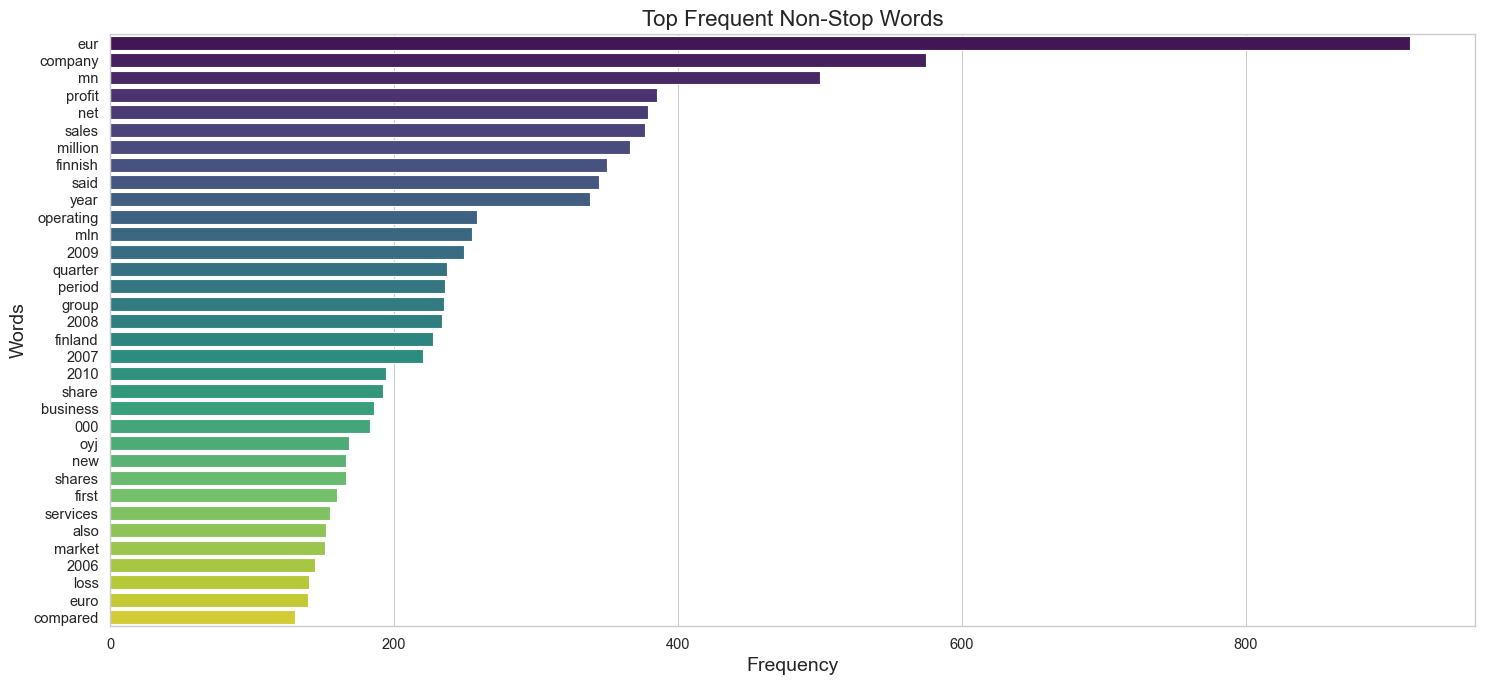

In [80]:
# Cell 4: Plot Most Frequent Non-Stop Words Using Counter and a Horizontal Bar Plot

# Count the frequency of all words in the corpus using Counter
counter = Counter(corpus)
most_common = counter.most_common(60)

# Filter out stop words from the most common words
words_filtered = []
counts_filtered = []
for word, count in most_common:
    if word not in stop:
        words_filtered.append(word)
        counts_filtered.append(count)

# Create a horizontal bar plot for the filtered non-stop words with different colors for each bar
plt.figure(figsize=(15, 7))
# Generate a color palette with as many colors as there are bars
palette = sns.color_palette("viridis", len(words_filtered))
sns.barplot(x=counts_filtered, y=words_filtered, palette=palette)
plt.title("Top Frequent Non-Stop Words", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Words", fontsize=14)
plt.tight_layout()
plt.show()



Top 10 Bigrams (Non-Stop Words):
net sales : 217
eur mn : 194
operating profit : 176
mn eur : 124
corresponding period : 103
mln euro : 94
net profit : 92
per share : 72
third quarter : 61
said today : 61

Top 10 Trigrams (Non-Stop Words):
mn corresponding period : 53
mln euro mln : 49
eur mn eur : 41
mn eur mn : 40
net sales eur : 30
earnings per share : 30
first nine months : 29
profit eur mn : 29
profit rose eur : 27
said today net : 26


C:\Users\admin\AppData\Local\Temp\ipykernel_48856\2060160791.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(bigram_counts), y=bigrams_labels, palette=palette)


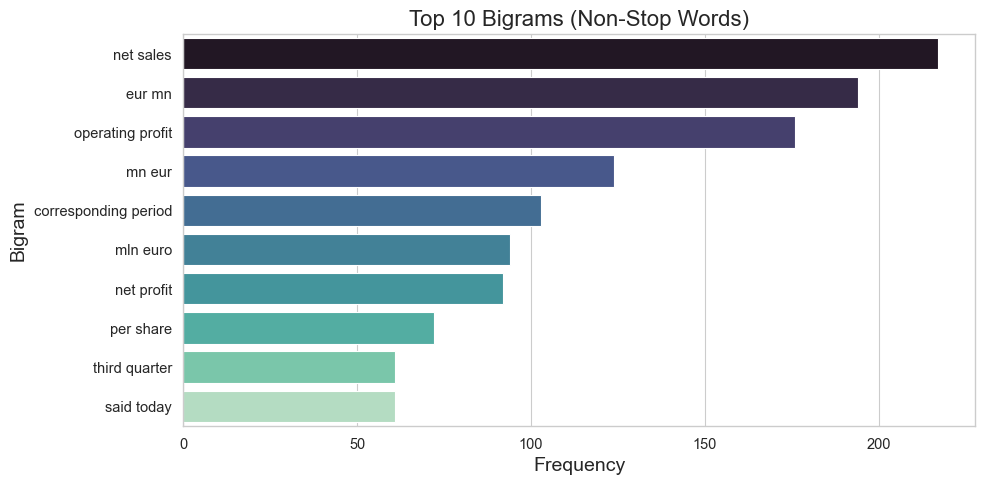

In [81]:
# Cell 5: N-gram Analysis (Bigram and Trigram Frequencies)
def get_ngram_frequencies(corpus, n=2, top_n=10):
    """
    Compute the top_n frequent n-grams from the corpus.
    """
    # Generate n-grams using nltk.util.ngrams
    n_grams = list(ngrams(corpus, n))
    # Count frequencies using Counter
    ngram_counts = Counter(n_grams)
    return ngram_counts.most_common(top_n)

# For n-gram analysis, filter the corpus to non-stop words
nonstop_corpus = [word for word in corpus if word not in stop]

# Get top 10 bigrams and trigrams
top_bigrams = get_ngram_frequencies(nonstop_corpus, n=2, top_n=10)
top_trigrams = get_ngram_frequencies(nonstop_corpus, n=3, top_n=10)

print("Top 10 Bigrams (Non-Stop Words):")
for ngram, count in top_bigrams:
    print(" ".join(ngram), ":", count)

print("\nTop 10 Trigrams (Non-Stop Words):")
for ngram, count in top_trigrams:
    print(" ".join(ngram), ":", count)

# Visualize bigrams frequencies using a horizontal bar plot with multiple colors
if top_bigrams:  # Ensure there is at least one bigram
    bigrams, bigram_counts = zip(*top_bigrams)
    bigrams_labels = [" ".join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 5))
    # Generate a color palette with as many colors as there are bars
    palette = sns.color_palette("mako", len(bigrams_labels))
    sns.barplot(x=list(bigram_counts), y=bigrams_labels, palette=palette)
    plt.title("Top 10 Bigrams (Non-Stop Words)", fontsize=16)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel("Bigram", fontsize=14)
    plt.tight_layout()
    plt.show()

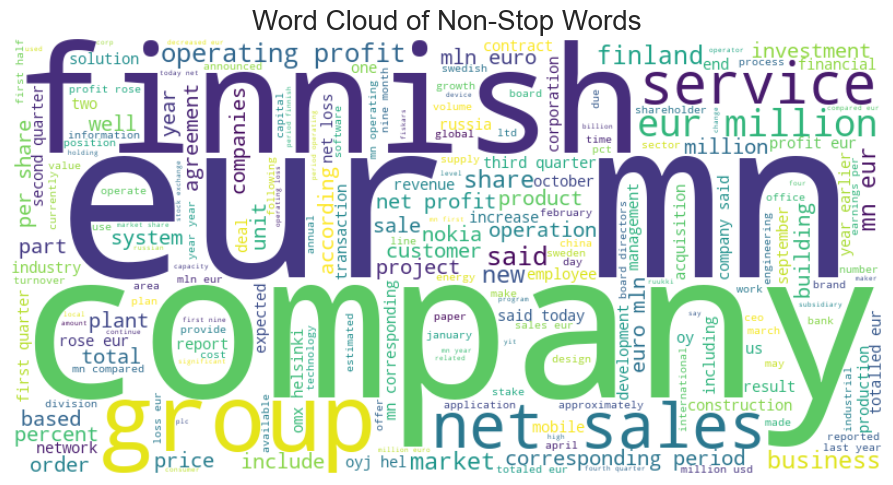

In [84]:
# Cell 6: Generate a Word Cloud for Non-Stop Words
# Join all non-stop words into a single string
nonstop_text = " ".join(nonstop_corpus)

# Create a WordCloud object with a white background
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(nonstop_text)

plt.figure(figsize=(15, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Non-Stop Words", fontsize=20)
plt.tight_layout()
plt.show()

#### FNN model

In [113]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    auc
)
from sklearn.preprocessing import label_binarize

In [116]:
# cell2: Cell 2: Data Preparation and Feature Extraction
# Text vectorization with TF-IDF
if df_finphrase is not None:
    tfidf = TfidfVectorizer(max_features=5000)
    X_train_tfidf = tfidf.fit_transform(X_train).toarray()
    X_test_tfidf = tfidf.transform(X_test).toarray()

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_tfidf)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_test_tensor = torch.FloatTensor(X_test_tfidf)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        TensorDataset(X_test_tensor, y_test_tensor),
        batch_size=batch_size
    )

In [118]:
# cell 3: Define the Neural Network Model
class SimpleFNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# Initialize model
num_classes = len(le.classes_)
model = SimpleFNN(input_dim=5000, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [119]:
# cell 4: Training the Model
# Track metrics
train_losses, test_losses = [], []
train_accs, test_accs = [], []
all_probs = []

# Training parameters
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()
    epoch_loss = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Evaluation phase
    model.eval()
    with torch.no_grad():
        # Training metrics
        train_outputs = model(X_train_tensor)
        train_loss = criterion(train_outputs, y_train_tensor).item()
        train_preds = torch.argmax(train_outputs, dim=1)
        train_acc = (train_preds == y_train_tensor).float().mean()
        
        # Test metrics
        test_outputs = model(X_test_tensor)
        test_probs = torch.softmax(test_outputs, dim=1)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_preds = torch.argmax(test_outputs, dim=1)
        test_acc = (test_preds == y_test_tensor).float().mean()
        
        # Store probabilities for ROC
        if epoch == num_epochs - 1:  # Only store final epoch probs
            all_probs = test_probs.numpy()
    
    # Record metrics
    train_losses.append(epoch_loss/len(train_loader))
    test_losses.append(test_loss)
    train_accs.append(train_acc.item())
    test_accs.append(test_acc.item())
    
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | "
          f"Test Loss: {test_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.4f} | "
          f"Test Acc: {test_accs[-1]:.4f}")

Epoch 1/10 | Train Loss: 0.9597 | Test Loss: 0.8083 | Train Acc: 0.6334 | Test Acc: 0.6319
Epoch 2/10 | Train Loss: 0.6952 | Test Loss: 0.6337 | Train Acc: 0.7462 | Test Acc: 0.7333
Epoch 3/10 | Train Loss: 0.5089 | Test Loss: 0.5410 | Train Acc: 0.8492 | Test Acc: 0.7928
Epoch 4/10 | Train Loss: 0.3596 | Test Loss: 0.4822 | Train Acc: 0.9282 | Test Acc: 0.8290
Epoch 5/10 | Train Loss: 0.2516 | Test Loss: 0.4574 | Train Acc: 0.9619 | Test Acc: 0.8420
Epoch 6/10 | Train Loss: 0.1879 | Test Loss: 0.4404 | Train Acc: 0.9797 | Test Acc: 0.8522
Epoch 7/10 | Train Loss: 0.1316 | Test Loss: 0.4393 | Train Acc: 0.9877 | Test Acc: 0.8507
Epoch 8/10 | Train Loss: 0.0965 | Test Loss: 0.4528 | Train Acc: 0.9913 | Test Acc: 0.8464
Epoch 9/10 | Train Loss: 0.0761 | Test Loss: 0.4610 | Train Acc: 0.9946 | Test Acc: 0.8420
Epoch 10/10 | Train Loss: 0.0603 | Test Loss: 0.4706 | Train Acc: 0.9978 | Test Acc: 0.8464


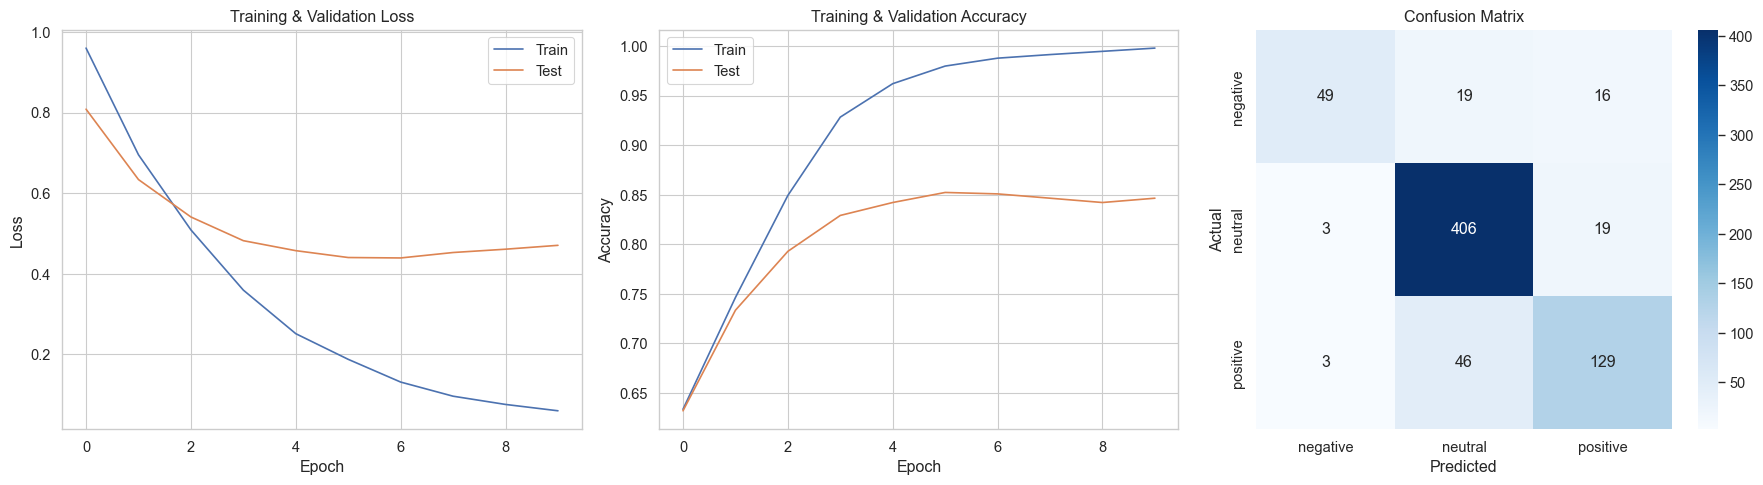

In [120]:
# cell 5: Visualizing Training Metrics
plt.figure(figsize=(18, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curves
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train')
plt.plot(test_accs, label='Test')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
plt.subplot(1, 3, 3)
final_preds = torch.argmax(model(X_test_tensor), dim=1).numpy()
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

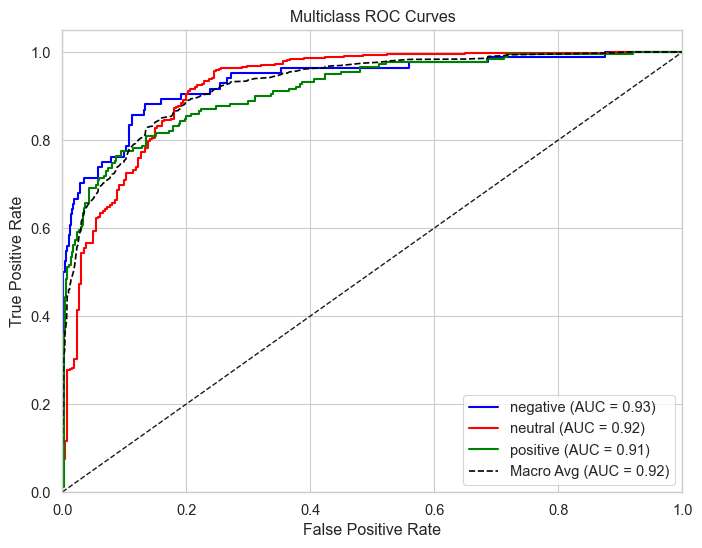

In [121]:
# cell 6: Classification Report and ROC Curve
# Binarize labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= num_classes
roc_auc["macro"] = auc(all_fpr, mean_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f'{le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(all_fpr, mean_tpr, color='black', linestyle='--', 
         label=f'Macro Avg (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [122]:
# cell 7: Print Classification Report
print("Classification Report:")
print(classification_report(y_test, final_preds, target_names=le.classes_))

print(f"\nMacro Average AUC: {roc_auc['macro']:.4f}")
print(f"Final Test Accuracy: {np.mean(final_preds == y_test):.4f}")

Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.58      0.71        84
     neutral       0.86      0.95      0.90       428
    positive       0.79      0.72      0.75       178

    accuracy                           0.85       690
   macro avg       0.85      0.75      0.79       690
weighted avg       0.85      0.85      0.84       690


Macro Average AUC: 0.9247
Final Test Accuracy: 0.8464
